# Build `MESH` Model Setup for the Nelson-Churchill River Basin

We use the `MESHFlow` Python package to build a `MESH` model setup for the Nelson-Churchill River Basin

It's also better to keep the geospatial fabric files next to the "agnostic" step's outputs:

In [1]:
!cp -r ../1-geofabric/SrsAboine-geofabric/ /home/fuaday/scratch/sras-agg-model/geofabric-outputs/

Let's start by importing the necessary libraries:

In [1]:
# import necessary libraries
import hydrant
import meshflow # version v0.1.0-dev1
import os # python 3.10.2

Now, let's provide necessary information to set up the `MESH` model:

In [2]:
# main work path - modify
work_path = '/home/fuaday/scratch/sras-agg-model/'
# using meshflow==v0.1.0-dev1
# modify each segment to match your settings
config = {
    'riv': os.path.join(work_path, 'geofabric-outputs', 'sras_rivers_MAF_Agg.shp'),
    'cat': os.path.join(work_path, 'geofabric-outputs', 'sras_subbasins_MAF_Agg.shp'),
    'landcover': os.path.join(work_path, 'gistool-outputs', 'sras_model_stats_NA_NALCMS_landcover_2015v2_30m.csv'),
    'forcing_files': os.path.join(work_path, 'easymore-outputsSel'),
    'forcing_vars': [ # does the variable list, match those of the "agnostic" step?
        "RDRS_v2.1_P_P0_SFC",
        "RDRS_v2.1_P_HU_09944",
        "RDRS_v2.1_P_TT_09944",
        "RDRS_v2.1_P_UVC_09944",
        "RDRS_v2.1_A_PR0_SFC",
        "RDRS_v2.1_P_FB_SFC",
        "RDRS_v2.1_P_FI_SFC",
    ],
    'forcing_units': { # Here, enter RDRS's original variable units
        'RDRS_v2.1_P_P0_SFC': 'millibar',
        'RDRS_v2.1_P_HU_09944': 'kg/kg',
        'RDRS_v2.1_P_TT_09944': 'celsius',
        'RDRS_v2.1_P_UVC_09944': 'knot',
        'RDRS_v2.1_A_PR0_SFC': 'm/hr',
        'RDRS_v2.1_P_FB_SFC': 'W/m^2',
        'RDRS_v2.1_P_FI_SFC': 'W/m^2',
    },
    'forcing_to_units': { # And here, the units that MESH needs to read
         'RDRS_v2.1_P_UVC_09944': 'm/s',
         'RDRS_v2.1_P_FI_SFC': 'W/m^2',
         'RDRS_v2.1_P_FB_SFC': 'W/m^2',
         'RDRS_v2.1_A_PR0_SFC': 'mm/s',
         'RDRS_v2.1_P_P0_SFC': 'pascal',
         'RDRS_v2.1_P_TT_09944': 'kelvin',
         'RDRS_v2.1_P_HU_09944': 'kg/kg',
    },
    'main_id': 'COMID', # what is the main ID of each river segment? Column name in the `cat` Shapefile
    'ds_main_id': 'NextDownID', # what is the downstream segment ID for each river segment? ditto.
    'landcover_classes': { # these are the classes defined for NALCMS-Landsat 2015 dataset. Is this accurate?      
        0: 'Unknown',
        1: 'Temperate or sub-polar needleleaf forest',
        2: 'Sub-polar taiga needleleaf forest',
        3: 'Tropical or sub-tropical broadleaf evergreen forest',
        4: 'Tropical or sub-tropical broadleaf deciduous forest',
        5: 'Temperate or sub-polar broadleaf deciduous forest',
        6: 'Mixed forest',
        7: 'Tropical or sub-tropical shrubland',
        8: 'Temperate or sub-polar shrubland',
        9: 'Tropical or sub-tropical grassland',
        10: 'Temperate or sub-polar grassland',
        11: 'Sub-polar or polar shrubland-lichen-moss',
        12: 'Sub-polar or polar grassland-lichen-moss',
        13: 'Sub-polar or polar barren-lichen-moss',
        14: 'Wetland',
        15: 'Cropland',
        16: 'Barren lands',
        17: 'Urban',
        18: 'Water',
        19: 'Snow and Ice',
    },
    'ddb_vars': { # the stuff that MESH needs: slope, river length, etc... Let me know if there is any issues here!
        'slope': 'ChnlSlope',
        'lengthkm': 'ChnlLength',
        'Rank': 'Rank',
        'Next': 'Next',
        'landcover': 'GRU',
        'unitarea': 'GridArea',
        'landcover_names': 'LandUse', #
        'order': 'IAK',  # 'ncontr': 'IWF'
        'uparea': 'DA'   
    },
    'ddb_units': {
        'ChnlSlope': 'm/m',
        'ChnlLength': 'km', # is it in km or m? Please check the units of the Shapefile you created!
        'Rank': 'dimensionless',
        'Next': 'dimensionless',
        'GRU': 'dimensionless',
        'GridArea': 'km^2', # what was the unit of the GridArea, or Shape_Area in the `catchments` Shapefile? #
        'IAK': 'dimensionless', #
        'DA': 'km^2',
        #'IWF': 'dimensionless',
    },
    'ddb_to_units': {
        'ChnlSlope': 'm/m',
        'ChnlLength': 'm', # This is what MESH needs, no need to change.
        'Rank': 'dimensionless',
        'Next': 'dimensionless',
        'GRU': 'dimensionless',
        'GridArea': 'm^2', # This is what MESH needs, no need to change. #
        'IAK': 'dimensionless', # 
        'DA': 'km^2',
        #'IWF': 'dimensionless',
    },
    'ddb_min_values': {
        'ChnlSlope': 1e-10, # in case there are 0s in the `rivers` Shapefile, we need minimums for certain variables
        'ChnlLength': 1e-3,
        'GridArea': 1e-3,
    },
    'gru_dim': 'NGRU', # change to `NGRU` for 'MESH>=r1860', keep for 'MESH<=1860', for example for r1813.
    'hru_dim': 'subbasin',
    'outlet_value': -9999,
}

We can build an "instance" of the workflow class:

In [3]:
exp1 = meshflow.MESHWorkflow(**config)

And, we can run it using:

In [4]:
exp1.run()

/home/fuaday/.local/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Once the run is finished, we can checkout the forcing and drainage database file:

In [5]:
exp1.forcing

<xarray.Dataset>
Dimensions:                (subbasin: 1792, time: 48)
Coordinates:
  * time                   (time) datetime64[ns] 1981-01-01T13:00:00 ... 1981...
  * subbasin               (subbasin) int32 71031862 71031180 ... 71039300
Data variables:
    RDRS_v2.1_P_P0_SFC     (subbasin, time) float64 9.542e+04 ... 1.006e+05
    RDRS_v2.1_P_HU_09944   (subbasin, time) float64 0.001596 ... 0.0001875
    RDRS_v2.1_P_TT_09944   (subbasin, time) float64 263.1 262.9 ... 242.2 241.2
    RDRS_v2.1_P_UVC_09944  (subbasin, time) float64 8.961 8.652 ... 4.24 3.004
    RDRS_v2.1_A_PR0_SFC    (subbasin, time) float64 1.547e-06 ... 2.967e-08
    RDRS_v2.1_P_FB_SFC     (subbasin, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RDRS_v2.1_P_FI_SFC     (subbasin, time) float64 261.0 260.8 ... 131.0 131.7
    lat                    (subbasin) float64 51.51 51.28 51.47 ... 51.46 49.88
    lon                    (subbasin) float64 -103.6 -103.5 ... -104.2 -97.16
    crs                    int64 1
Attributes:
    author:       University of Calgary
    license:      GNU General Public License v3 (or any later version)
    purpose:      Create forcing .nc file for MESH
    Conventions:  CF-1.6
    history:      Created using MESHFlow version v0.1.0.dev1

In [6]:
exp1.ddb

<xarray.Dataset>
Dimensions:     (subbasin: 1792, NGRU: 13)
Coordinates:
  * subbasin    (subbasin) int32 71031862 71031180 ... 71029760 71039300
Dimensions without coordinates: NGRU
Data variables:
    ChnlSlope   (subbasin) float64 0.002923 8.642e-05 ... 0.0003172 0.001262
    ChnlLength  (subbasin) float64 2.753e+04 1.502e+04 ... 1e+03 6.958e+03
    Rank        (subbasin) int32 1 2 3 4 5 6 7 ... 1787 1788 1789 1790 1791 1792
    Next        (subbasin) int32 5 11 15 15 15 16 17 17 17 ... 0 0 0 0 0 0 0 0 0
    GRU         (subbasin, NGRU) float64 5.906e-05 0.0 0.04652 ... 0.04042 0.0
    GridArea    (subbasin) float64 1.067e+08 7.149e+07 ... 8.458e+06 5.601e+06
    LandUse     (NGRU) <U49 'Temperate or sub-polar needleleaf forest' ... 'D...
    IAK         (subbasin) float64 1.0 1.0 1.0 1.0 2.0 ... 2.0 2.0 2.0 2.0 7.0
    DA          (subbasin) float64 106.7 71.49 50.49 ... 193.7 235.7 1.509e+05
    lat         (subbasin) float64 51.51 51.28 51.47 51.42 ... 51.73 51.46 49.88
    lon         (subbasin) float64 -103.6 -103.5 -103.5 ... -104.4 -104.2 -97.16
    crs         int64 1
Attributes:
    author:       University of Calgary
    license:      GNU General Public License v3 (or any later version)
    purpose:      Create a drainage database .nc file for MESH
    featureType:  point

In [7]:
# create a directory for MESH setup
try:
    os.makedirs('/home/fuaday/scratch/sras-agg-model/MESH-sras-agg')
except FileExistsError:
    pass
# saving drainage database and forcing files
exp1.save('/home/fuaday/scratch/sras-agg-model/MESH-sras-agg/')

Now that the two important files are built, we can copy a series of setting files into the output path:

In [ ]:
#!cp -r setting_files/* /home/fuaday/scratch/ncrb-models/MESH-ncrb/
#!mkdir -p /home/fuaday/scratch/ncrb-models/MESH-ncrb/results/

# SECTION II

# Build `MESH_parameters.nc` file, representing the spatial parameterization

In [2]:
from MESHpyPreProcessing.gsde_soil import GSDESoil
from MESHpyPreProcessing.NetCDFWriter import NetCDFWriter 

In [3]:
# Define paths and directories
directory = '/home/fuaday/scratch/sras-agg-model/gistool-outputs'
#/scratch/fuaday/sras-agg-model/gistool-outputs
input_basin = '/home/fuaday/scratch/sras-agg-model/geofabric-outputs/sras_subbasins_MAF_Agg2.shp'
output_river_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_subbasins_MAF_Agg2.shp"
output_shapefile = 'merged_soil_data_shapefile4.shp'

# File names for soil data
file_names = ['sras_model_stats_CLAY1.csv', 'sras_model_stats_CLAY2.csv', 'sras_model_stats_SAND1.csv', 'sras_model_stats_SAND2.csv',
              'sras_model_stats_OC1.csv', 'sras_model_stats_OC2.csv',
             'sras_model_stats_BDRICM_M_250m_ll.csv', 'sras_model_stats_BDTICM_M_250m_ll.csv']

# Define search and replace names for column cleaning otherwise it will be too long on the shapefile column
searchname = ['_depth=4.5', '_depth=9.1000004', '_depth=16.6', '_depth=28.9', '_depth=49.299999', '_depth=82.900002', '_depth=138.3', '_depth=229.60001', '_x', '_y']
replacename = ['1', '2', '3', '4', '5', '6', '7', '8', 'BDRICM', 'BDTICM']

# Properties and column names
#This is to crete automatically the names for 8 layers like {'CLAY': ['meanCLAY1', 'meanCLAY2', ... ,  'meanCLAY8'], 'SAND': ['meanSAND1',  'meanSAND2', ... ,  'meanSAND8'],
#    'BD': ['meanBD1',  'meanBD2', ... ,  'meanBD8'], 'OC': ['meanOC1',  'meanOC2', ... ,  'meanOC8']}
column_names = {prop: [f'mean{prop}{depth}' for depth in ['1', '2', '3', '4', '5', '6', '7', '8']] for prop in ['CLAY', 'SAND', 'OC']}

# Define intervals, This is default gsde depth interval for 8 layers 
gsde_intervals = [(0, 0.045), (0.045, 0.091), (0.091, 0.166), (0.166, 0.289), (0.289, 0.493), (0.493, 0.829), (0.829, 1.383), (1.383, 2.296)]
# This is input and defines the MESH soil depth discritizaiton, in the following case 4 layers soil
mesh_intervals = [(0, 0.1), (0.1, 0.35), (0.35, 1.2), (1.2, 4.1)]

# Initialize GSDESoil and process the data
gsde = GSDESoil(directory, input_basin, output_shapefile)
gsde.load_data(file_names)
gsde.clean_column_names(searchname, replacename)
gsde.fill_and_clean_data()
gsde.calculate_weights(gsde_intervals, mesh_intervals)
gsde.calculate_mesh_values(column_names)


<AxesSubplot:>

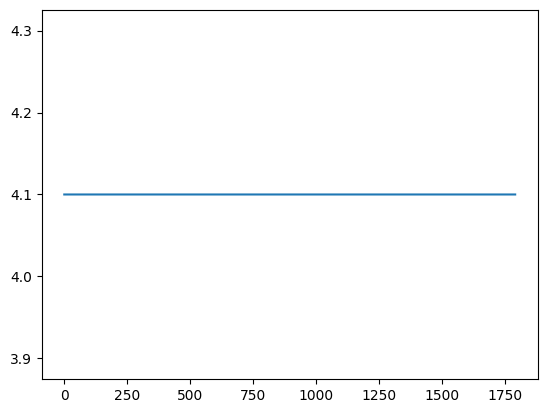

In [4]:
gsde.gsde_df.meanBDTICM.plot()

In [5]:
print(list(gsde.gsde_df.columns))

['COMID', 'minCLAY1', 'minCLAY2', 'minCLAY3', 'minCLAY4', 'maxCLAY1', 'maxCLAY2', 'maxCLAY3', 'maxCLAY4', 'meanCLAY1', 'meanCLAY2', 'meanCLAY3', 'meanCLAY4', 'medianCLAY1', 'medianCLAY2', 'medianCLAY3', 'medianCLAY4', 'minCLAY5', 'minCLAY6', 'minCLAY7', 'minCLAY8', 'maxCLAY5', 'maxCLAY6', 'maxCLAY7', 'maxCLAY8', 'meanCLAY5', 'meanCLAY6', 'meanCLAY7', 'meanCLAY8', 'medianCLAY5', 'medianCLAY6', 'medianCLAY7', 'medianCLAY8', 'minSAND1', 'minSAND2', 'minSAND3', 'minSAND4', 'maxSAND1', 'maxSAND2', 'maxSAND3', 'maxSAND4', 'meanSAND1', 'meanSAND2', 'meanSAND3', 'meanSAND4', 'medianSAND1', 'medianSAND2', 'medianSAND3', 'medianSAND4', 'minSAND5', 'minSAND6', 'minSAND7', 'minSAND8', 'maxSAND5', 'maxSAND6', 'maxSAND7', 'maxSAND8', 'meanSAND5', 'meanSAND6', 'meanSAND7', 'meanSAND8', 'medianSAND5', 'medianSAND6', 'medianSAND7', 'medianSAND8', 'minOC1', 'minOC2', 'minOC3', 'minOC4', 'maxOC1', 'maxOC2', 'maxOC3', 'maxOC4', 'meanOC1', 'meanOC2', 'meanOC3', 'meanOC4', 'medianOC1', 'medianOC2', 'medianO

In [6]:
gsde.merge_and_save_shapefile()

/home/fuaday/.local/lib/python3.10/site-packages/MESHpyPreProcessing/gsde_soil.py:212: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  self.merged_gdf.to_file(self.output_shapefile)


In [7]:
from MESHpyPreProcessing.NetCDFWriter import NetCDFWriter

# Paths for NetCDFWriter
nc_filename = 'MESH_parameters3.nc'
output_shapefile = 'merged_soil_data_shapefile4.shp'
input_ddb = '/scratch/fuaday/sras-agg-model/MESH-sras-agg/MESH_drainage_database.nc'
mesh_intervals = [(0, 0.1), (0.1, 0.35), (0.35, 1.2), (1.2, 4.1)]

# Initialize NetCDFWriter with the necessary paths
nc_writer = NetCDFWriter(
    nc_filename=nc_filename,
    shapefile_path=output_shapefile,
    input_ddb_path=input_ddb
)

# Read shapefile and set coordinates from the input drainage database
nc_writer.read_shapefile()
nc_writer.set_coordinates()

# Set the number of soil layers (example with 4 layers, as indicated by the column names)
nc_writer.set_num_soil_layers(num_layers=len(mesh_intervals))

# Define the properties for NetCDF writing, distinguishing between layer-dependent and layer-independent properties
properties = {
    'layer_dependent': ['CLAY', 'SAND', 'OC'],  # Dependent on number of soil layers and subbasin
    'layer_independent': ['ncontr','meanBDRICM','meanBDTICM']  # Dependent only on subbasin 
}

# Define variable information with names and data types, and unit
variable_info = {
    'CLAY': ('CLAY', 'f4', 'Percentage'),
    'SAND': ('SAND', 'f4', 'Percentage'),
    'OC': ('ORGM', 'f4', 'Percentage'),
    'ncontr': ('IWF', 'i4', '1'),
    'meanBDRICM': ('BDRICM', 'f4', 'Meters'),
    'meanBDTICM': ('BDTICM', 'f4', 'Meters')
}

# Write the data to a NetCDF file
nc_writer.write_netcdf(properties=properties, variable_info=variable_info)


In [8]:
!cp MESH_parameters3.nc /home/fuaday/scratch/sras-agg-model/MESH-sras-agg

____